In [1]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np

In [5]:
class CNN(torch.nn.Module):
    def __init__(self, num_class):
        super(CNN, self).__init__()
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # input: (N,88,168,2)
            
            # conv: 2 -> 16 ch, 3x3 (stride-1)
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            # conv: 16 -> 32 -> 32 ch, 3x3
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            # conv: 32 -> 64 -> 64, 3x3
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            
            # conv: 64 -> 128 -> 128 ch
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU(),
        )
        
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )
    
    def forward(self, x):
        net = self._feature(x)
        # average over spacial dimensions to flatten
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))

In [6]:
class BLOB:
    pass

blob = BLOB()
blob.net = CNN(3).cuda()
blob.criterion = torch.nn.CrossEntropyLoss()
blob.optimizer = torch.optim.Adam(blob.net.parameters())
blob.softmax   = torch.nn.Softmax(dim=1)
blob.data      = None
blob.label     = None

In [20]:
def forward(blob,train=True):
    """
    Args: blob should have attributes: net, criterion, softmax, data, label
    Returns: a dictionary of predicted labels, softmax, loss and accuracy
    """
    with torch.set_grad_enabled(train):
        # prediction
        data = torch.as_tensor(blob.data).cuda()
        data = data.permute(0,3,1,2) # I think we bring the "channel" before the spacial dimension here
        prediction = blob.net(data)
        
        # training
        loss,acc = -1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()
            label.requires_grad = False # because we don't train this, sav space
            loss = blob.criterion(prediction,label) # evaluate loss function
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        prediction = prediction.cpu().detach().numpy()
        
        return {
            'prediction': prediction,
            'softmax':    softmax,
            'loss':       loss,
            'accuracy':   accuracy
        }

def backward(blob):
    blob.optimizer.zero_grad() # reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

In [21]:
!rm -f iotools/iotools
!rm -f iotools
!rm -f utils
!ln -s ../ExampleNotebooks/iotools/ iotools
!ln -s ../ExampleNotebooks/utils/ utils

In [22]:
# create data loader
from iotools import loader_factory
DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']

# for train
train_loader = loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.2)

# for validation
test_loader = loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.2, use_fraction=0.1)

In [23]:
from utils import progress_bar, CSVData
blob.train_log = CSVData('02-log_train.csv')
blob.test_log  = CSVData('02-log_test.csv')

In [25]:
TRAIN_EPOCH = 3.0 # one epoch is having processed all data once

blob.net.train()
epoch=0.
iteration=0

# start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
    # create progressbar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    for i,data in enumerate(train_loader):
        blob.data,blob.label = data[0:2]
        # make prediction and measure avg error
        res = forward(blob,train=True)
        # back-propopagate
        backward(blob)
        # epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        # log/report
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%100 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,train=False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train() # set back to training mode
        if (epoch >= TRAIN_EPOCH):
            break
    
    # final result of this epoch (not done yet)
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()    

Epoch 0 Starting @ 2019-04-16 03:18:47


Epoch 1 Starting @ 2019-04-16 03:20:08


Epoch 2 Starting @ 2019-04-16 03:21:26


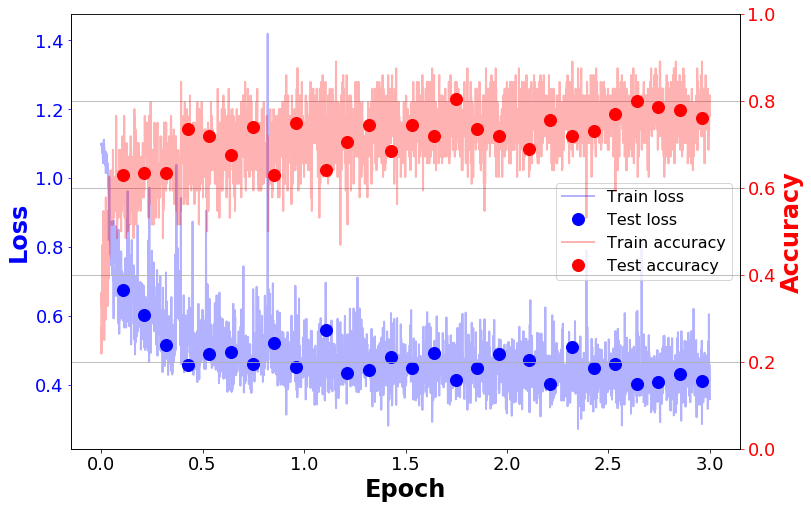

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8), facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch,  test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss',fontsize=24,fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch,  test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold', color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.)

lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

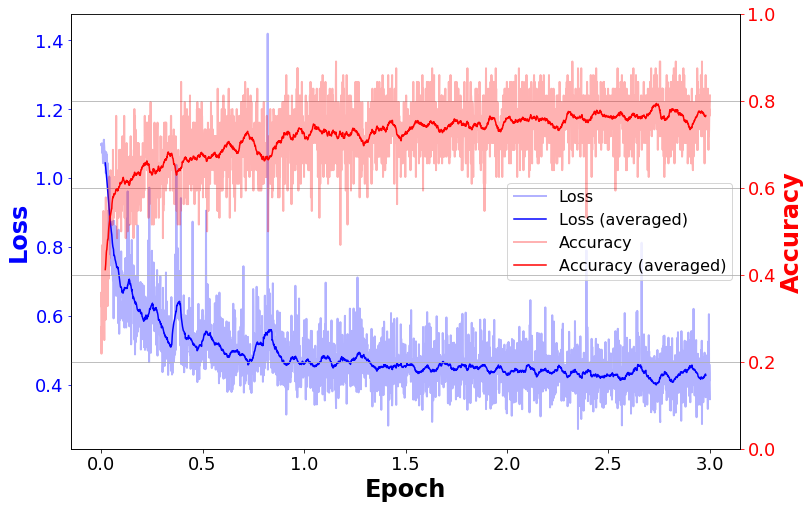

In [30]:
def moving_average(a,n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[(n-1):] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8), facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss',fontsize=24,fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold', color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.)

lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [35]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    blob.net.eval() # eval mode
    index,label,prediction = [],[],[]
    
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,train=False)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        # if i == 2: break
    
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

Accuracy mean 0.75906664 std 0.02895621


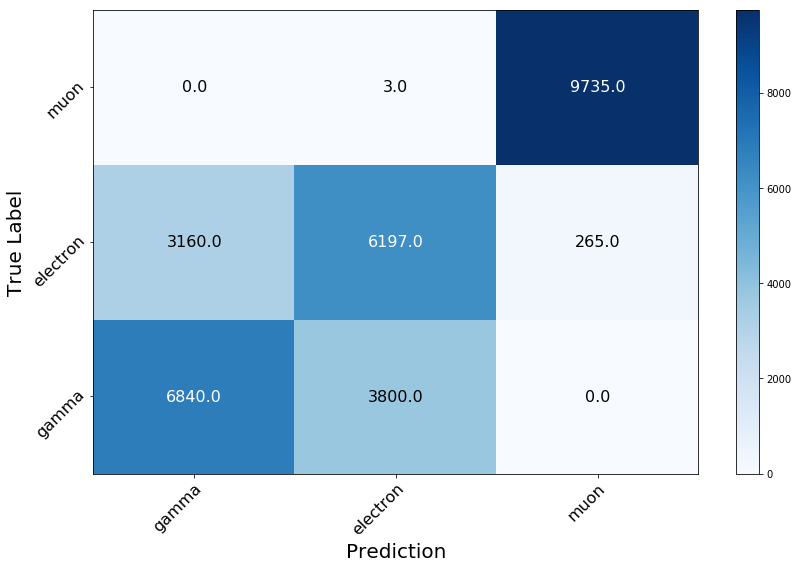

In [36]:
from utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['gamma','electron','muon'])